Tải dữ liệu từ Github về máy

Import thư viện cần thiết

In [7]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from scipy import sparse
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [8]:
BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

In [9]:
sns.set_context("notebook")

RANDOM_STATE = 42

SPLIT_RATIOS = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]  # train:val = 4:1; 7:3; 6:4

DATA_DIR = os.path.join(BASE_DIR, "data")

FILES = {
    "df_4": "processed_data_4_classes.csv",
    "df_9": "processed_data_9_classes.csv",
    "df_4_pca_6": "X_4_classes_PCA_6dims.csv",
    "df_4_lda_2": "X_4_classes_LDA_2dims.csv",
    "df_9_pca_6": "X_9_classes_PCA_6dims.csv",
    "df_9_lda_2": "X_9_classes_LDA_2dims.csv",
}

def read_csv(filename: str) -> pd.DataFrame:
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Không tìm thấy file: {path}")
    return pd.read_csv(path)

df_4 = read_csv(FILES["df_4"])
df_9 = read_csv(FILES["df_9"])
df_4_pca_6 = read_csv(FILES["df_4_pca_6"])
df_4_lda_2 = read_csv(FILES["df_4_lda_2"])
df_9_pca_6 = read_csv(FILES["df_9_pca_6"])
df_9_lda_2 = read_csv(FILES["df_9_lda_2"])

print("Shapes:")
print("df_4 :", df_4.shape)
print("df_9:", df_9.shape)
print("df_4_pca_6:", df_4_pca_6.shape)
print("df_4_lda_2 :", df_4_lda_2.shape)
print("df_9_pca_6:", df_9_pca_6.shape)
print("df_9_lda_2:", df_9_lda_2.shape)

Shapes:
df_4 : (1067, 15)
df_9: (1101, 15)
df_4_pca_6: (1067, 7)
df_4_lda_2 : (1067, 3)
df_9_pca_6: (1101, 7)
df_9_lda_2: (1101, 3)


Đọc dữ liệu

In [10]:
from sklearn.preprocessing import LabelEncoder

def split_X_y(df: pd.DataFrame, label_col: str = "Classification"):
    if label_col not in df.columns:
        raise ValueError(f"Thiếu cột nhãn '{label_col}' trong dataframe.")
    X = df.drop(columns=[label_col])
    y = df[label_col]
    return X, y

X4, y4 = split_X_y(df_4)
X9, y9 = split_X_y(df_9)

X4_pca6, y4_pca6 = split_X_y(df_4_pca_6)
X4_lda2, y4_lda2 = split_X_y(df_4_lda_2)

X9_pca6, y9_pca6 = split_X_y(df_9_pca_6)
X9_lda2, y9_lda2 = split_X_y(df_9_lda_2)

# Naive Bayes (dữ liệu full)

In [11]:
# Label Encoding
y4_encoded, y4_labels = pd.factorize(y4)
y9_encoded, y9_labels = pd.factorize(y9)


def fit_gnb(X_train: np.ndarray, y_train: np.ndarray, eps: float = 1e-9):
    """
    Fit Gaussian NB for labels encoded 0..C-1
    """
    classes = np.unique(y_train)
    C = len(classes)
    d = X_train.shape[1]

    priors = np.zeros(C, dtype=np.float64)
    means  = np.zeros((C, d), dtype=np.float64)
    vars_  = np.zeros((C, d), dtype=np.float64)

    for c in classes:
        Xc = X_train[y_train == c]
        priors[c] = Xc.shape[0] / X_train.shape[0]
        means[c]  = Xc.mean(axis=0)
        vars_[c]  = Xc.var(axis=0) + eps

    return priors, means, vars_


def _logsumexp(A, axis=1):
    m = np.max(A, axis=axis, keepdims=True)
    return m + np.log(np.sum(np.exp(A - m), axis=axis, keepdims=True) + 1e-12)


def predict_gnb_proba(X_test: np.ndarray, priors: np.ndarray, means: np.ndarray, vars_: np.ndarray):
    """
    Return posterior probabilities P(y=c|x) for each sample.
    Shape: (n_samples, C)
    """
    n = X_test.shape[0]
    C = priors.shape[0]

    log_priors = np.log(priors + 1e-12)
    log_probs = np.zeros((n, C), dtype=np.float64)

    for c in range(C):
        term1 = -0.5 * np.log(2.0 * np.pi * vars_[c])
        term2 = -0.5 * ((X_test - means[c]) ** 2) / vars_[c]
        log_likelihood = (term1 + term2).sum(axis=1)
        log_probs[:, c] = log_priors[c] + log_likelihood

    proba = np.exp(log_probs - _logsumexp(log_probs, axis=1))
    return proba


def naive_bayes_gnb(X_features, y_encoded, class_labels, split_ratios):
    """
    Gaussian Naive Bayes
    - Return: acc_list, avg_acc, best_split, best_artifacts
    """
    X_all = X_features.to_numpy() if isinstance(X_features, pd.DataFrame) else np.asarray(X_features)
    y_all = np.asarray(y_encoded).astype(int)

    acc_list = []
    best_acc = -1.0
    best_split = None
    best_payload = None

    for ratio in split_ratios:
        test_size = ratio[1]
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=test_size, random_state=42, stratify=y_all
        )

        priors, means, vars_ = fit_gnb(X_train, y_train)
        y_proba = predict_gnb_proba(X_test, priors, means, vars_)   # (n, C)
        y_pred = np.argmax(y_proba, axis=1).astype(int)

        acc = accuracy_score(y_test, y_pred)
        acc_list.append(acc)

        print(
            f'Accuracy \033[31mGaussian Naive Bayes\033[0m bằng dữ liệu gốc '
            f'với train/test = \033[31m{ratio[0]}/{ratio[1]}\033[0m: \033[31m{acc}\033[0m'
        )

        if acc > best_acc:
            best_acc = acc
            best_split = ratio
            best_payload = {
                "y_true": y_test,
                "y_pred": y_pred,
                "y_proba": y_proba,
                "class_names": list(class_labels)  # label gốc
            }

    avg_acc = sum(acc_list) / len(acc_list)
    print(f'Avg accuracy (GNB): \033[31m{avg_acc}\033[0m\n')

    return acc_list, avg_acc, best_split, best_payload

print('\033[33mPhân loại 4 class\033[0m')
gnb_acc_4, gnb_avg_4, gnb_best_split_4, gnb_best_payload_4 = naive_bayes_gnb(
    X4, y4_encoded, y4_labels, SPLIT_RATIOS
)

print('\033[33mPhân loại 9 class\033[0m')
gnb_acc_9, gnb_avg_9, gnb_best_split_9, gnb_best_payload_9 = naive_bayes_gnb(
    X9, y9_encoded, y9_labels, SPLIT_RATIOS
)


Phân loại 4 class
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.8/0.2: 0.8598130841121495
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.7/0.3: 0.8660436137071651
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.6/0.4: 0.8548009367681498
Avg accuracy (GNB): 0.8602192115291548

Phân loại 9 class
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.8/0.2: 0.8416289592760181
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.7/0.3: 0.851963746223565
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.6/0.4: 0.8390022675736961
Avg accuracy (GNB): 0.8441983243577598



Classification Report and Confusion Matrix and Corrlation for best train/test split

4 class:
Best split (train/test) = 0.7/0.3
Best Accuracy: 0.8660
Best Precision: 0.8875
Best Recall: 0.8660
Classification Report:
              precision    recall  f1-score   support

        C2S1       0.75      1.00      0.86        75
        C3S1       0.98      0.85      0.91       209
        C4S2       0.50      0.45      0.48        11
        C4S1       0.68      0.81      0.74        26

    accuracy                           0.87       321
   macro avg       0.73      0.78      0.75       321
weighted avg       0.89      0.87      0.87       321



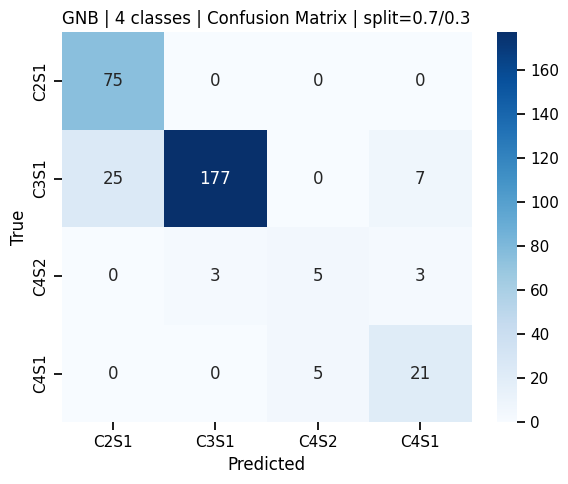

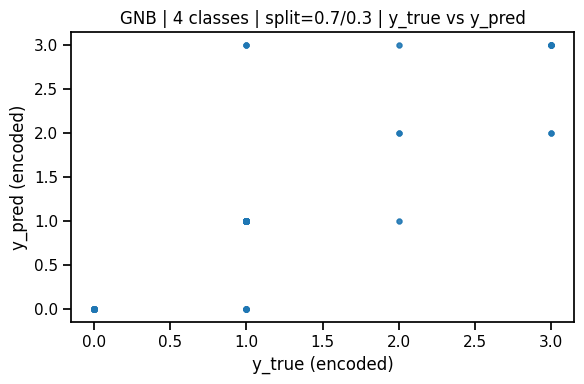

,class,"corr(onehot, proba)"
0,C2S1,0.830810
1,C3S1,0.805049
2,C4S2,0.500074
3,C4S1,0.780695


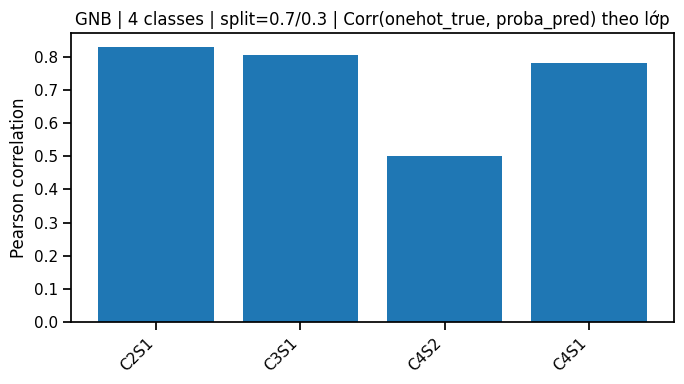

9 class:
Best split (train/test) = 0.7/0.3
Best Accuracy: 0.8520
Best Precision: 0.8714
Best Recall: 0.8520
Classification Report:
              precision    recall  f1-score   support

        C2S1       0.75      1.00      0.86        75
        C3S1       0.98      0.83      0.90       209
        C4S2       0.50      0.45      0.48        11
        C4S1       0.66      0.81      0.72        26
        C3S2       0.50      0.75      0.60         4
        C4S4       1.00      1.00      1.00         2
        C4S3       0.00      0.00      0.00         1
        C3S3       0.67      1.00      0.80         2
          OG       0.00      0.00      0.00         1

    accuracy                           0.85       331
   macro avg       0.56      0.65      0.60       331
weighted avg       0.87      0.85      0.85       331



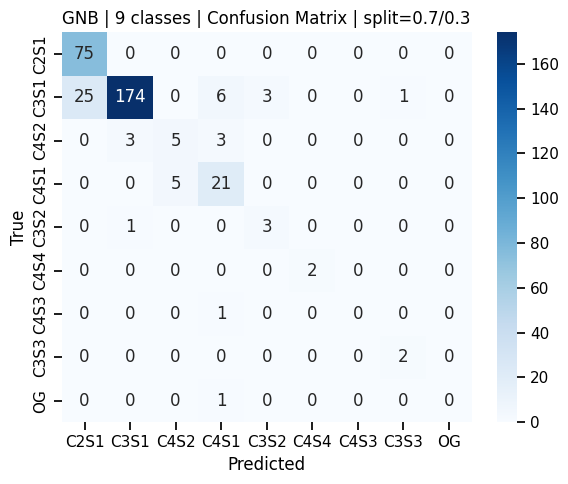

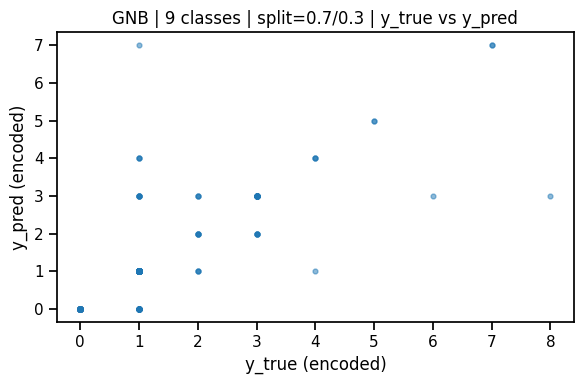

,class,"corr(onehot, proba)"
0,C2S1,0.832497
1,C3S1,0.789927
2,C4S2,0.500798
3,C4S1,0.762385
4,C3S2,0.625365
5,C4S4,0.989911
6,C4S3,-0.004136
7,C3S3,0.786213
8,OG,NaN


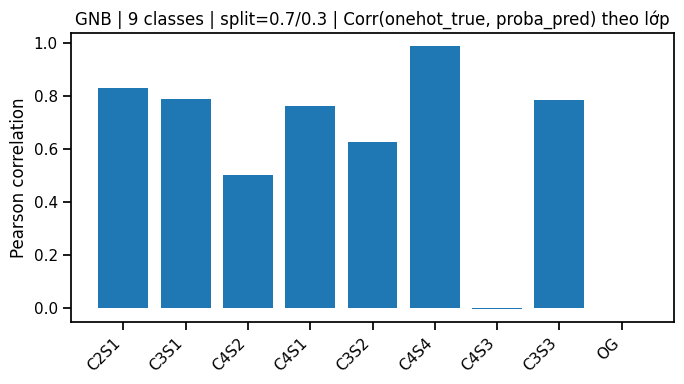

In [12]:
def prediction_correlation_plots(y_true, y_pred, y_proba, class_names, title_prefix: str):
    # Scatter y_true vs y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, s=12, alpha=0.5)
    plt.title(f"{title_prefix} | y_true vs y_pred")
    plt.xlabel("y_true (encoded)")
    plt.ylabel("y_pred (encoded)")
    plt.tight_layout()
    plt.show()

    # Correlation per class:
    n_classes = len(class_names)
    onehot = np.zeros((len(y_true), n_classes))
    onehot[np.arange(len(y_true)), y_true] = 1

    corrs = []
    for k in range(n_classes):
        a = onehot[:, k]
        b = y_proba[:, k]
        # Nếu phương sai = 0 thì corr undefined
        if np.std(a) < 1e-12 or np.std(b) < 1e-12:
            corrs.append(np.nan)
        else:
            corrs.append(np.corrcoef(a, b)[0, 1])

    corr_df = pd.DataFrame({"class": class_names, "corr(onehot, proba)": corrs})
    display(corr_df)

    plt.figure(figsize=(7, 4))
    plt.bar(corr_df["class"], np.nan_to_num(corr_df["corr(onehot, proba)"], nan=0.0))
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{title_prefix} | Corr(onehot_true, proba_pred) theo lớp")
    plt.ylabel("Pearson correlation")
    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred, class_names, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


y4_true = gnb_best_payload_4["y_true"]
y4_pred = gnb_best_payload_4["y_pred"]
y4_proba = gnb_best_payload_4["y_proba"]
class_names_4 = gnb_best_payload_4["class_names"]

y9_true = gnb_best_payload_9["y_true"]
y9_pred = gnb_best_payload_9["y_pred"]
y9_proba = gnb_best_payload_9["y_proba"]
class_names_9 = gnb_best_payload_9["class_names"]



# 4 class
print('\033[33m4 class:\033[0m')
print(f"\033[33mBest split (train/test) = {gnb_best_split_4[0]}/{gnb_best_split_4[1]}\033[0m")
print(f"\033[32mBest Accuracy: {accuracy_score(y4_true, y4_pred):.4f}\033[0m")
print(f"\033[32mBest Precision: {precision_score(y4_true, y4_pred, average='weighted', zero_division=0):.4f}\033[0m")
print(f"\033[32mBest Recall: {recall_score(y4_true, y4_pred, average='weighted', zero_division=0):.4f}\033[0m")
print("Classification Report:")
print(classification_report(y4_true, y4_pred, target_names=class_names_4, zero_division=0))

plot_confusion(
    y4_true, y4_pred, class_names=class_names_4,
    title=f"GNB | 4 classes | Confusion Matrix | split={gnb_best_split_4[0]}/{gnb_best_split_4[1]}"
)
prediction_correlation_plots(
    y_true=y4_true, y_pred=y4_pred, y_proba=y4_proba, class_names=class_names_4,
    title_prefix=f"GNB | 4 classes | split={gnb_best_split_4[0]}/{gnb_best_split_4[1]}"
)



# 9 class
print('\033[33m9 class:\033[0m')
print(f"\033[33mBest split (train/test) = {gnb_best_split_9[0]}/{gnb_best_split_9[1]}\033[0m")
print(f"\033[32mBest Accuracy: {accuracy_score(y9_true, y9_pred):.4f}\033[0m")
print(f"\033[32mBest Precision: {precision_score(y9_true, y9_pred, average='weighted', zero_division=0):.4f}\033[0m")
print(f"\033[32mBest Recall: {recall_score(y9_true, y9_pred, average='weighted', zero_division=0):.4f}\033[0m")
print("Classification Report:")
print(classification_report(y9_true, y9_pred, target_names=class_names_9, zero_division=0))

plot_confusion(
    y9_true, y9_pred, class_names=class_names_9,
    title=f"GNB | 9 classes | Confusion Matrix | split={gnb_best_split_9[0]}/{gnb_best_split_9[1]}"
)
prediction_correlation_plots(
    y_true=y9_true, y_pred=y9_pred, y_proba=y9_proba, class_names=class_names_9,
    title_prefix=f"GNB | 9 classes | split={gnb_best_split_9[0]}/{gnb_best_split_9[1]}"
)

Kết quả tương quan giữa nhãn one-hot và xác suất dự đoán cho thấy mô hình GNB hoạt động không đồng đều giữa các lớp (9 class). Một số lớp có tương quan cao, phản ánh khả năng phân biệt tốt (C2S1, C4S4) do đặc trưng hóa học cao, trong khi các lớp hiếm hoặc chồng lấn cho thấy tương quan thấp hoặc không xác định. Điều này phù hợp với giả thiết Gaussian độc lập của GNB và đặc điểm phân bố dữ liệu.

# MLP (Với dữ liệu Full, sử dụng Softmax làm active function)

In [13]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis=0, keepdims=True))
    Z = e_V / (e_V.sum(axis=0, keepdims=True) + 1e-12)
    return Z

def cost(Y, Yhat):
    return -np.sum(Y * np.log(Yhat + 1e-12)) / Y.shape[1]

def convert_labels(y, C):
    Y = sparse.coo_matrix(
        (np.ones_like(y), (y, np.arange(len(y)))),
        shape=(C, len(y))
    ).toarray()
    return Y

def relu(Z):
    return np.maximum(Z, 0)


def init_mlp(d0, d1, d2, seed=42):
    rng = np.random.default_rng(seed)
    W1 = 0.01 * rng.standard_normal((d0, d1))
    b1 = np.zeros((d1, 1))
    W2 = 0.01 * rng.standard_normal((d1, d2))
    b2 = np.zeros((d2, 1))
    return W1, b1, W2, b2

def forward_mlp(X, W1, b1, W2, b2):
    Z1 = W1.T @ X + b1        # (d1, N)
    A1 = relu(Z1)             # (d1, N)
    Z2 = W2.T @ A1 + b2       # (C, N)
    Yhat = softmax(Z2)        # (C, N)
    cache = (X, Z1, A1, Z2, Yhat)
    return Yhat, cache

def backward_mlp(cache, Y, W1, W2, l2=0.0):
    X, Z1, A1, Z2, Yhat = cache
    N = X.shape[1]

    E2 = (Yhat - Y) / N       # (C, N)
    dW2 = A1 @ E2.T + l2 * W2 # L2 regularization
    db2 = np.sum(E2, axis=1, keepdims=True)

    E1 = W2 @ E2
    E1[Z1 <= 0] = 0           # ReLU grad

    dW1 = X @ E1.T + l2 * W1  # L2 regularization
    db1 = np.sum(E1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

def train_mlp(
    X, y,
    hidden=100,
    lr=1e-2,
    iters=5000,
    l2=0.0,
    print_every=500,
    seed=42
):
    """
    X: (d0, N) ; y: (N,) encoded 0..C-1
    Prints iter loss and returns trained weights.
    """
    d0 = X.shape[0]
    C = int(np.max(y)) + 1
    Y = convert_labels(y, C)

    W1, b1, W2, b2 = init_mlp(d0, hidden, C, seed=seed)

    for i in range(iters):
        Yhat, cache = forward_mlp(X, W1, b1, W2, b2)
        if i % print_every == 0:
            loss = cost(Y, Yhat)
            print(f"iter {i}, loss: {loss:.6f}")

        dW1, db1, dW2, db2 = backward_mlp(cache, Y, W1, W2, l2=l2)

        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    return W1, b1, W2, b2

def predict_proba_mlp(X, W1, b1, W2, b2):
    Yhat, _ = forward_mlp(X, W1, b1, W2, b2)
    return Yhat  # (C, N)

def predict_class_mlp(X, W1, b1, W2, b2):
    proba = predict_proba_mlp(X, W1, b1, W2, b2)
    return np.argmax(proba, axis=0).astype(int)  # (N,)

def mlp_run_splits(
    X_features, y_encoded, class_labels,
    split_ratios,
    hidden=100, lr=1e-2, iters=6000, l2=0.0
):
    """
    Return acc_list, avg_acc, best_split, best_payload
    best_payload: y_true, y_pred, y_proba, class_names để vẽ
    """
    X_all = X_features.to_numpy() if isinstance(X_features, pd.DataFrame) else np.asarray(X_features)
    y_all = np.asarray(y_encoded).astype(int)

    acc_list = []
    best_acc = -1
    best_split = None
    best_payload = None

    for ratio in split_ratios:
        test_size = ratio[1]

        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=test_size, random_state=42, stratify=y_all
        )

        # scale
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s  = scaler.transform(X_test)

        # to (d0, N)
        Xtr = X_train_s.T
        Xte = X_test_s.T

        # train
        print(f"\nTrain MLP split {ratio[0]}/{ratio[1]} ...")
        W1, b1, W2, b2 = train_mlp(
            Xtr, y_train,
            hidden=hidden, lr=lr, iters=iters,
            l2=l2, print_every=max(1, iters // 10), seed=42
        )

        # predict
        y_pred = predict_class_mlp(Xte, W1, b1, W2, b2)
        y_proba = predict_proba_mlp(Xte, W1, b1, W2, b2).T  # -> (N, C) cho plot correlation

        acc = accuracy_score(y_test, y_pred)
        acc_list.append(acc)

        print(
            f'Accuracy \033[31mMLP (Softmax)\033[0m bằng dữ liệu gốc '
            f'với train/test = \033[31m{ratio[0]}/{ratio[1]}\033[0m: \033[31m{acc}\033[0m'
        )

        if acc > best_acc:
            best_acc = acc
            best_split = ratio
            best_payload = {
                "y_true": y_test,
                "y_pred": y_pred,
                "y_proba": y_proba,
                "class_names": list(class_labels),
                "model": (W1, b1, W2, b2),
                "scaler": scaler
            }

    avg_acc = sum(acc_list) / len(acc_list)
    print(f'Avg accuracy (MLP): \033[31m{avg_acc}\033[0m\n')

    return acc_list, avg_acc, best_split, best_payload


# 4 class
print('\033[33mPhân loại 4 class\033[0m')
mlp_acc_4, mlp_avg_4, mlp_best_split_4, mlp_best_payload_4 = mlp_run_splits(
    X4, y4_encoded, y4_labels, SPLIT_RATIOS,
    hidden=100, lr=1e-2, iters=6000, l2=0.0
)

# 9 class
print('\033[33mPhân loại 9 class\033[0m')
mlp_acc_9, mlp_avg_9, mlp_best_split_9, mlp_best_payload_9 = mlp_run_splits(
    X9, y9_encoded, y9_labels, SPLIT_RATIOS,
    hidden=150, lr=8e-3, iters=9000, l2=0.0
)

Phân loại 4 class

Train MLP split 0.8/0.2 ...
iter 0, loss: 1.386364
iter 600, loss: 0.816261
iter 1200, loss: 0.454130
iter 1800, loss: 0.333652
iter 2400, loss: 0.274496
iter 3000, loss: 0.239473
iter 3600, loss: 0.216788
iter 4200, loss: 0.201111
iter 4800, loss: 0.189597
iter 5400, loss: 0.180674
Accuracy MLP (Softmax) bằng dữ liệu gốc với train/test = 0.8/0.2: 0.9392523364485982

Train MLP split 0.7/0.3 ...
iter 0, loss: 1.386351
iter 600, loss: 0.815917
iter 1200, loss: 0.450385
iter 1800, loss: 0.325913
iter 2400, loss: 0.264515
iter 3000, loss: 0.228152
iter 3600, loss: 0.204541
iter 4200, loss: 0.188201
iter 4800, loss: 0.176239
iter 5400, loss: 0.166973
Accuracy MLP (Softmax) bằng dữ liệu gốc với train/test = 0.7/0.3: 0.9314641744548287

Train MLP split 0.6/0.4 ...
iter 0, loss: 1.386370
iter 600, loss: 0.823236
iter 1200, loss: 0.450643
iter 1800, loss: 0.327077
iter 2400, loss: 0.266800
iter 3000, loss: 0.230895
iter 3600, loss: 0.207453
iter 4200, loss: 0.191229
iter 4800

Classification Report and Confusion Matrix and Corrlation for best train/test split

Best split 4-class (train/test) = 0.8/0.2
Best Accuracy: 0.9393
Best Precision: 0.9379
Best Recall: 0.9393
MLP - 4 class:
Classification Report:
              precision    recall  f1-score   support

        C2S1       0.91      0.98      0.94        50
        C3S1       0.98      0.96      0.97       140
        C4S2       0.50      0.43      0.46         7
        C4S1       0.88      0.82      0.85        17

    accuracy                           0.94       214
   macro avg       0.82      0.80      0.81       214
weighted avg       0.94      0.94      0.94       214



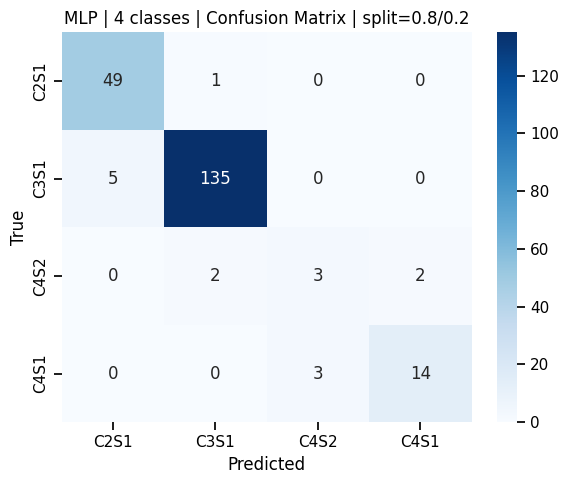

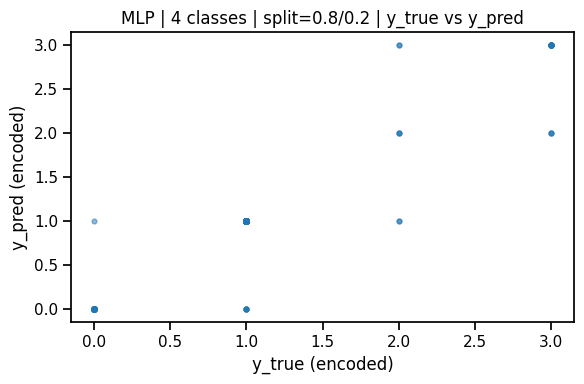

,class,"corr(onehot, proba)"
0,C2S1,0.940354
1,C3S1,0.933224
2,C4S2,0.621744
3,C4S1,0.902238


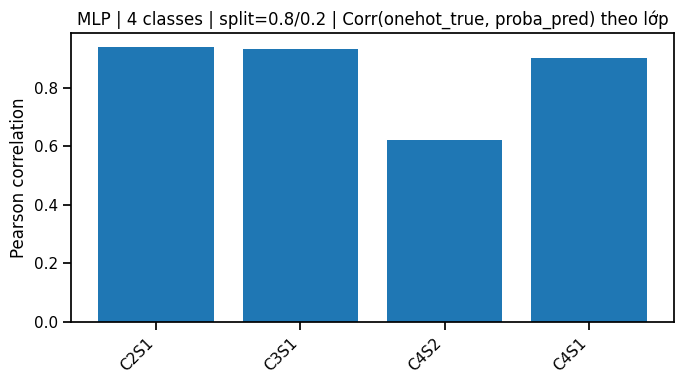

Best split 9-class (train/test) = 0.6/0.4
Best Accuracy: 0.9161
Best Precision: 0.9074
Best Recall: 0.9161
MLP - 9 class:
Classification Report:
              precision    recall  f1-score   support

        C2S1       0.88      0.99      0.93        99
        C3S1       0.96      0.95      0.96       279
        C4S2       0.50      0.43      0.46        14
        C4S1       0.88      0.86      0.87        35
        C3S2       0.50      0.20      0.29         5
        C4S4       0.50      1.00      0.67         3
        C4S3       1.00      0.50      0.67         2
        C3S3       0.00      0.00      0.00         2
          OG       0.00      0.00      0.00         2

    accuracy                           0.92       441
   macro avg       0.58      0.55      0.54       441
weighted avg       0.91      0.92      0.91       441



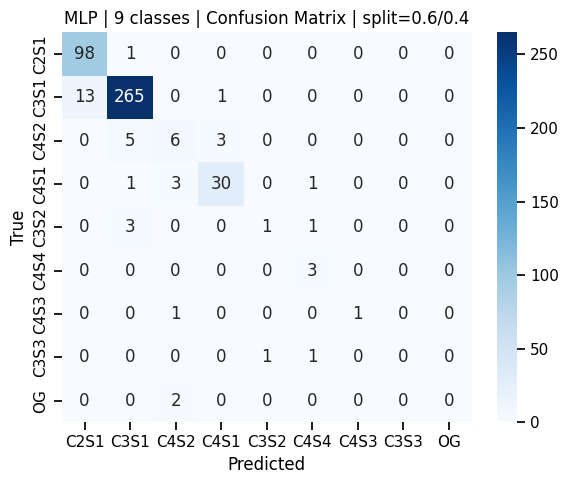

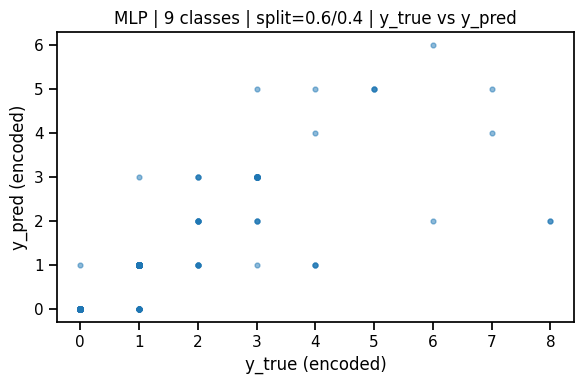

,class,"corr(onehot, proba)"
0,C2S1,0.937330
1,C3S1,0.907910
2,C4S2,0.463580
3,C4S1,0.876172
4,C3S2,0.483693
5,C4S4,0.815785
6,C4S3,0.398803
7,C3S3,0.489791
8,OG,0.417628


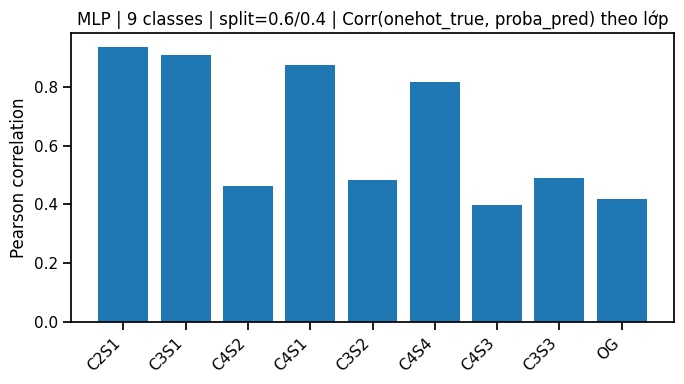

In [14]:
# 4 class
print(f"\033[33mBest split 4-class (train/test) = {mlp_best_split_4[0]}/{mlp_best_split_4[1]}\033[0m")
y4_true = mlp_best_payload_4["y_true"]
y4_pred = mlp_best_payload_4["y_pred"]
y4_proba = mlp_best_payload_4["y_proba"]
class_names_4 = mlp_best_payload_4["class_names"]
print(f"\033[32mBest Accuracy: {accuracy_score(y4_true, y4_pred):.4f}\033[0m")
print(f"\033[32mBest Precision: {precision_score(y4_true, y4_pred, average='weighted', zero_division=0):.4f}\033[0m")
print(f"\033[32mBest Recall: {recall_score(y4_true, y4_pred, average='weighted', zero_division=0):.4f}\033[0m")

print('\033[33mMLP - 4 class:\033[0m')
print("Classification Report:")
print(classification_report(y4_true, y4_pred, target_names=class_names_4, zero_division=0))

plot_confusion(
    y4_true, y4_pred, class_names=class_names_4,
    title=f"MLP | 4 classes | Confusion Matrix | split={mlp_best_split_4[0]}/{mlp_best_split_4[1]}"
)
prediction_correlation_plots(
    y_true=y4_true, y_pred=y4_pred, y_proba=y4_proba, class_names=class_names_4,
    title_prefix=f"MLP | 4 classes | split={mlp_best_split_4[0]}/{mlp_best_split_4[1]}"
)

# 9 class
print(f"\033[33mBest split 9-class (train/test) = {mlp_best_split_9[0]}/{mlp_best_split_9[1]}\033[0m")
y9_true = mlp_best_payload_9["y_true"]
y9_pred = mlp_best_payload_9["y_pred"]
y9_proba = mlp_best_payload_9["y_proba"]
class_names_9 = mlp_best_payload_9["class_names"]
print(f"\033[32mBest Accuracy: {accuracy_score(y9_true, y9_pred):.4f}\033[0m")
print(f"\033[32mBest Precision: {precision_score(y9_true, y9_pred, average='weighted', zero_division=0):.4f}\033[0m")
print(f"\033[32mBest Recall: {recall_score(y9_true, y9_pred, average='weighted', zero_division=0):.4f}\033[0m")

print('\033[33mMLP - 9 class:\033[0m')
print("Classification Report:")
print(classification_report(y9_true, y9_pred, target_names=class_names_9, zero_division=0))

plot_confusion(
    y9_true, y9_pred, class_names=class_names_9,
    title=f"MLP | 9 classes | Confusion Matrix | split={mlp_best_split_9[0]}/{mlp_best_split_9[1]}"
)
prediction_correlation_plots(
    y_true=y9_true, y_pred=y9_pred, y_proba=y9_proba, class_names=class_names_9,
    title_prefix=f"MLP | 9 classes | split={mlp_best_split_9[0]}/{mlp_best_split_9[1]}"
)


Hiệu chỉnh tăng nhẹ L2 và giảm hidden layer

In [15]:
print('\033[33m[Regularization] MLP 4-class (L2)\033[0m')
mlp_acc_4_reg, mlp_avg_4_reg, mlp_best_split_4_reg, mlp_best_payload_4_reg = mlp_run_splits(
    X4, y4_encoded, y4_labels, SPLIT_RATIOS,
    hidden=64, lr=1e-2, iters=7000, l2=1e-3
)

print('\033[33m[Regularization] MLP 9-class (L2)\033[0m')
mlp_acc_9_reg, mlp_avg_9_reg, mlp_best_split_9_reg, mlp_best_payload_9_reg = mlp_run_splits(
    X9, y9_encoded, y9_labels, SPLIT_RATIOS,
    hidden=100, lr=8e-3, iters=10000, l2=1e-3
)

print("\n\033[33mSo sánh Avg accuracy:\033[0m")
print(f"4-class: before={mlp_avg_4:.6f} | after(L2)={mlp_avg_4_reg:.6f}")
print(f"9-class: before={mlp_avg_9:.6f} | after(L2)={mlp_avg_9_reg:.6f}")


[Regularization] MLP 4-class (L2)

Train MLP split 0.8/0.2 ...
iter 0, loss: 1.385722
iter 700, loss: 0.756063
iter 1400, loss: 0.419888
iter 2100, loss: 0.317251
iter 2800, loss: 0.265520
iter 3500, loss: 0.233475
iter 4200, loss: 0.211950
iter 4900, loss: 0.196819
iter 5600, loss: 0.185651
iter 6300, loss: 0.177046
Accuracy MLP (Softmax) bằng dữ liệu gốc với train/test = 0.8/0.2: 0.9392523364485982

Train MLP split 0.7/0.3 ...
iter 0, loss: 1.385733
iter 700, loss: 0.755991
iter 1400, loss: 0.415355
iter 2100, loss: 0.309245
iter 2800, loss: 0.255500
iter 3500, loss: 0.222204
iter 4200, loss: 0.199821
iter 4900, loss: 0.184009
iter 5600, loss: 0.172338
iter 6300, loss: 0.163380
Accuracy MLP (Softmax) bằng dữ liệu gốc với train/test = 0.7/0.3: 0.9345794392523364

Train MLP split 0.6/0.4 ...
iter 0, loss: 1.385758
iter 700, loss: 0.763530
iter 1400, loss: 0.415750
iter 2100, loss: 0.310479
iter 2800, loss: 0.257535
iter 3500, loss: 0.224360
iter 4200, loss: 0.201845
iter 4900, loss: 0.

# Classification -> Regression

Xây dựng lại MLP với kết quả trả về là xác suất của hàm quyết định (Softmax). Chọn phân lớp mục tiêu là phân lớp phổ biến nhất

In [16]:
def build_regression_target_from_mlp(
    X_features, y_encoded,
    hidden=100, lr=1e-2, iters=6000, l2=0.0,
    test_size=0.2,
    target_class=None
):
    """
    Train MLP classifier, return y_reg
    y_reg = softmax probability of chosen class
    """
    X_all = X_features.to_numpy() if hasattr(X_features, "to_numpy") else np.asarray(X_features)
    y_all = np.asarray(y_encoded).astype(int)

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=42, stratify=y_all
    )

    # chọn lớp mục tiêu (lớp nhiều nhất)
    if target_class is None:
        vals, cnts = np.unique(y_train, return_counts=True)
        target_class = int(vals[np.argmax(cnts)])

    # scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # (d0, N)
    Xtr = X_train_s.T
    Xte = X_test_s.T

    # train MLP
    W1, b1, W2, b2 = train_mlp(
        Xtr, y_train,
        hidden=hidden, lr=lr, iters=iters,
        l2=l2, print_every=max(1, iters // 10)
    )

    # softmax probabilities
    proba_train = predict_proba_mlp(Xtr, W1, b1, W2, b2)
    proba_test  = predict_proba_mlp(Xte, W1, b1, W2, b2)

    y_reg_train = proba_train[target_class, :]
    y_reg_test  = proba_test[target_class, :]

    return (
        X_train_s, X_test_s,
        y_reg_train, y_reg_test,
        target_class
    )


Hồi quy với đầu ra từ Softmax, thực hiện trên 3 mô hình: Linear Regression, Ridge Regression và Random Forest


In [17]:
def regression_experiments(Xtr, Xte, ytr, yte):
    regressors = {
        "LinearRegression": LinearRegression(),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
        "RandomForest": RandomForestRegressor(
            n_estimators=300, random_state=42, n_jobs=-1
        )
    }

    results = []

    for name, reg in regressors.items():
        reg.fit(Xtr, ytr)
        y_pred = reg.predict(Xte)

        rmse = np.sqrt(mean_squared_error(yte, y_pred))
        mae  = mean_absolute_error(yte, y_pred)
        r2   = r2_score(yte, y_pred)

        results.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

    return pd.DataFrame(results)


In [18]:
print("\033[33mMLP → Regression (4 class)\033[0m")

Xtr_4, Xte_4, ytr_4, yte_4, target_class_4 = build_regression_target_from_mlp(
    X4, y4_encoded,
    hidden=100, lr=1e-2, iters=6000,
    test_size=0.2
)

print(f"Target class index: {target_class_4}")

reg_results_4 = regression_experiments(Xtr_4, Xte_4, ytr_4, yte_4)
display(reg_results_4)

print("--------------------------------------------------")

print("\033[33mMLP → Regression (9 class)\033[0m")

Xtr_9, Xte_9, ytr_9, yte_9, target_class_9 = build_regression_target_from_mlp(
    X9, y9_encoded,
    hidden=100, lr=1e-2, iters=6000,
    test_size=0.2
)

print(f"Target class index: {target_class_9}")

reg_results_9 = regression_experiments(Xtr_9, Xte_9, ytr_9, yte_9)
display(reg_results_9)

MLP → Regression (4 class)
iter 0, loss: 1.386364
iter 600, loss: 0.816261
iter 1200, loss: 0.454130
iter 1800, loss: 0.333652
iter 2400, loss: 0.274496
iter 3000, loss: 0.239473
iter 3600, loss: 0.216788
iter 4200, loss: 0.201111
iter 4800, loss: 0.189597
iter 5400, loss: 0.180674
Target class index: 1


,Model,RMSE,MAE,R2
0,LinearRegression,0.374969,0.325983,0.169568
1,Ridge(alpha=1.0),0.373895,0.326245,0.174319
2,RandomForest,0.067048,0.032733,0.973448


--------------------------------------------------
MLP → Regression (9 class)
iter 0, loss: 2.197148
iter 600, loss: 1.035054
iter 1200, loss: 0.602605
iter 1800, loss: 0.465003
iter 2400, loss: 0.393516
iter 3000, loss: 0.346983
iter 3600, loss: 0.316107
iter 4200, loss: 0.294226
iter 4800, loss: 0.277471
iter 5400, loss: 0.264176
Target class index: 1


,Model,RMSE,MAE,R2
0,LinearRegression,0.382617,0.337076,0.134327
1,Ridge(alpha=1.0),0.381766,0.337075,0.138173
2,RandomForest,0.070306,0.035496,0.970771


Linear Regression: Kết quả kém nhất, RMSE cao, R^2 thấp -> Quan hệ giữa đặc trưng và xác suất softmax không tuyến tính

Ridge Regression: Kết quả cải thiện nhẹ so với Linear Regression

Random Forest: Kết quả tốt nhất, chỉ số RMSE thấp, R^2 cao -> Khai thác được cấu trúc phức tạp của xác suất softmax


Nhận xét:
Do đầu ra của hàm MLP là một hàm phi tuyến phức tạp của đầu vào. Nên 2 mô hình hồi quy tuyến tính không đủ khả năng để dự đoán chính xác, trong khi đó Random Forest phù hợp hơn.
-> Xác suất dự đoán của MLP chứa nhiều thông tin định lượng qua trọng, có thể khai thác tốt bởi các mô hình hồi quy phi tuyến

# Scatter

Vẽ scatter cho 3 mô hình hồi quy

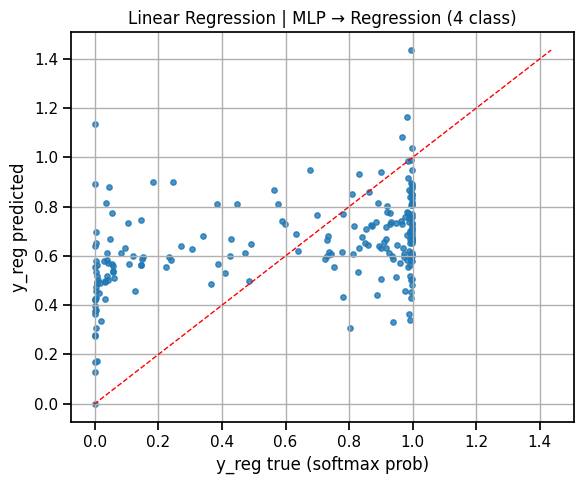

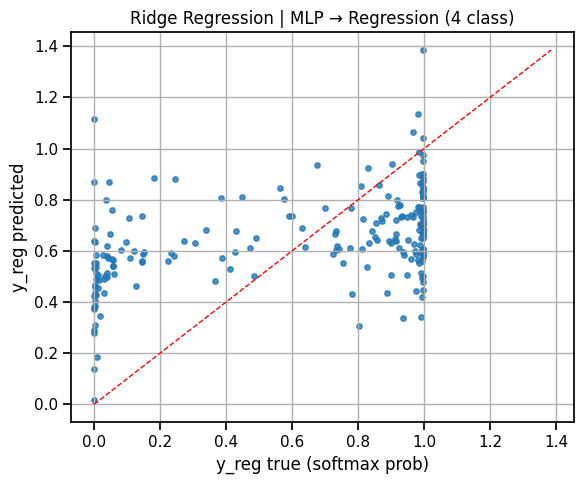

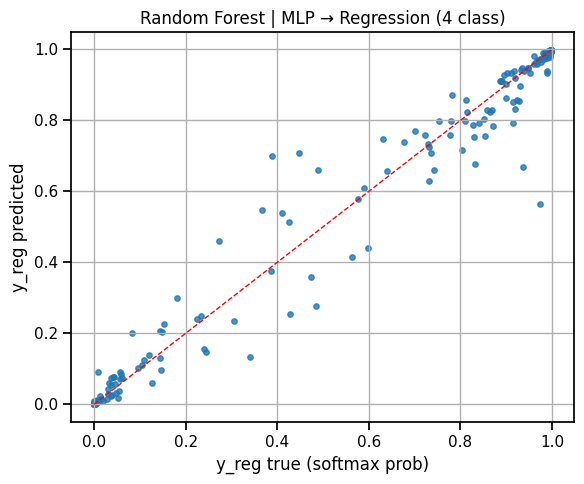

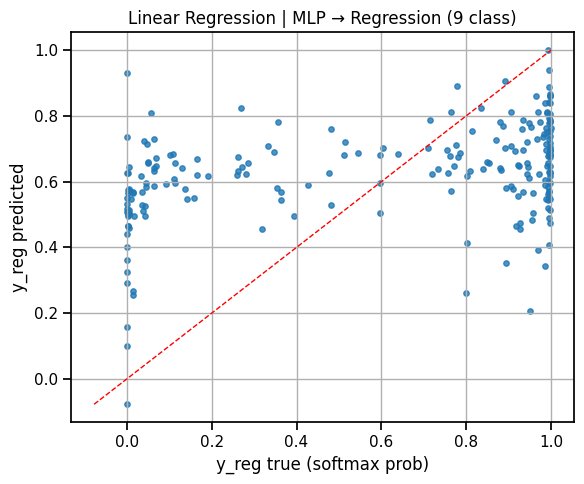

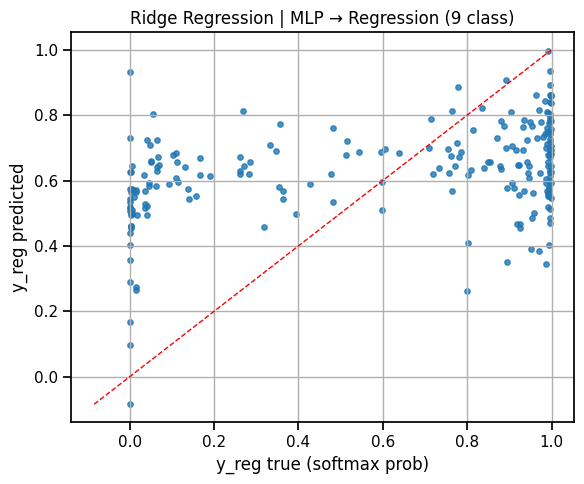

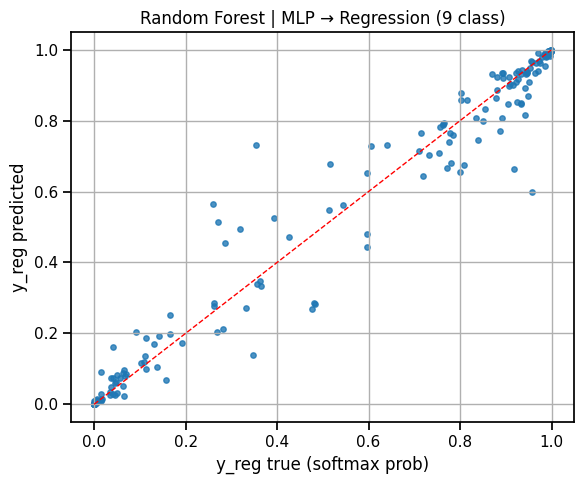

In [19]:
def plot_regression_scatter(y_true, y_pred, model_name, title_suffix=""):
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, s=15, alpha=0.8)
    minv = min(y_true.min(), y_pred.min())
    maxv = max(y_true.max(), y_pred.max())
    plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)

    plt.xlabel("y_reg true (softmax prob)")
    plt.ylabel("y_reg predicted")
    plt.title(f"{model_name} | {title_suffix}")
    plt.grid()
    plt.tight_layout()
    plt.show()

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

for name, reg in regressors.items():
    reg.fit(Xtr_4, ytr_4)
    y_pred_4 = reg.predict(Xte_4)
    plot_regression_scatter(
        yte_4, y_pred_4,
        model_name=name,
        title_suffix="MLP → Regression (4 class)"
    )

for name, reg in regressors.items():
    reg.fit(Xtr_9, ytr_9)
    y_pred_9 = reg.predict(Xte_9)
    plot_regression_scatter(
        yte_9, y_pred_9,
        model_name=name,
        title_suffix="MLP → Regression (9 class)"
    )


# Thực hiện với dữ liệu đã giảm chiều

In [20]:
X4_pca6, y4_pca6 = split_X_y(df_4_pca_6)
X4_lda2, y4_lda2 = split_X_y(df_4_lda_2)

X9_pca6, y9_pca6 = split_X_y(df_9_pca_6)
X9_lda2, y9_lda2 = split_X_y(df_9_lda_2)

Giảm về còn 6 chiều với PCA

In [21]:
# Label Encoding
y4_pca6_encoded, y4_pca6_labels = pd.factorize(y4_pca6)
y9_pca6_encoded, y9_pca6_labels = pd.factorize(y9_pca6)

print('\033[33mPhân loại 4 class\033[0m')
gnb_acc_4, gnb_avg_4, gnb_best_split_4, gnb_best_payload_4 = naive_bayes_gnb(
    X4_pca6, y4_pca6_encoded, y4_pca6_labels, SPLIT_RATIOS
)

print('\033[33mPhân loại 9 class\033[0m')
gnb_acc_9, gnb_avg_9, gnb_best_split_9, gnb_best_payload_9 = naive_bayes_gnb(
    X9_pca6, y9_pca6_encoded, y9_pca6_labels, SPLIT_RATIOS
)

Phân loại 4 class
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.8/0.2: 0.883177570093458
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.7/0.3: 0.8629283489096573
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.6/0.4: 0.8688524590163934
Avg accuracy (GNB): 0.8716527926731695

Phân loại 9 class
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.8/0.2: 0.8642533936651584
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.7/0.3: 0.8429003021148036
Accuracy Gaussian Naive Bayes bằng dữ liệu gốc với train/test = 0.6/0.4: 0.8503401360544217
Avg accuracy (GNB): 0.8524979439447945

